# Deep latent variable generative models

In generative modelling, we have a dataset sampled from a probability distribution $X \sim P(X)$. We want to learn a model which can approximate this distribution.

In latent variable models, we assume that the factors of variation of the data are explained by hidden (latent) variables $Z$. At inference time, we can sample values of $Z$ and generate data by using our model to predict $P(X \vert Z)$.

First, create a dataset. We use the two moons dataset. 

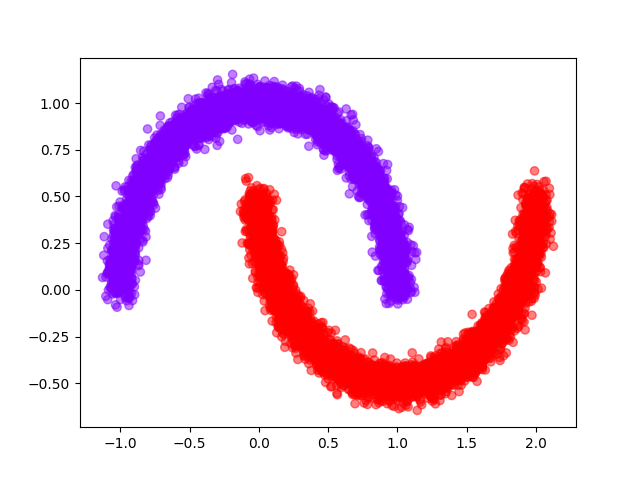

In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets as datasets
import torch
from torch.utils.data import DataLoader, Dataset, random_split

# we save images to outputs/ and read them instead of displaying them directly,
# this helps fix a matplotlib bug when doing live colla
os.makedirs("outputs", exist_ok=True)


class MoonsDataset(Dataset):
    def __init__(self, n_samples=10000, noise=0.01):
        X, y = datasets.make_moons(n_samples=10000, noise=noise)
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray)

        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


ds = MoonsDataset(noise=.05)
n_train, n_val, n_test = 6000, 2000, 2000
train_ds, val_ds, test_ds = random_split(ds, [n_train, n_val, n_test])

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False, num_workers=4)

plt.scatter(ds.X[:, 0], ds.X[:, 1], c=ds.y, cmap="rainbow", alpha=0.5)
plt.savefig("outputs/moons.png")
plt.close()
Image.open("outputs/moons.png").show()


## Monte-Carlo Expectation Maximisation

The Monte-Carlo approximation of the integral is given by:

$\begin{aligned} \log p(x) &= \log \int p(x, z) dz \\ &= \log \int p(x \vert z)p(z) \\ &\approx \log \frac{1}{M}\sum_{m=1}^{M}p(x \vert z_m)p(z_m), \quad z_m \sim p(z)\end{aligned}$

We can obtain an algorithm by selecting parametric forms for the latent prior $p(z)$ and conditional posterior $p(x \vert z)$.

For example, we can choose the latent prior to be a standard Gaussian: $p(z) \sim \mathcal{N}(0, 1)$ and the conditional posterior to be a Gaussian distribution with fixed variance and mean parameterised by a neural network: $p(x|z) \sim \mathcal{N}(\mu_\theta(z), \sigma^2_\theta(z))$.

Using Maximum Likelihood Estimation (MLE) for the model's parameters, we obtain the following objective:

$\theta^* = \begin{aligned}\arg \max_{\theta}\frac{1}{N}\sum_{n=1}^N\log  \frac{1}{M}\sum_{m=1}^M p_\theta(x \vert z_m)p(z_m) \quad z_m \sim p(z)\end{aligned}$

We can obtain parameter estimates by using expectation maximisation or mini-batch gradient descent.

4999/5000: Loss 0.656: : 5000it [02:27, 33.83it/s]
/tmp/ipykernel_22735/2557566047.py:85: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(samples[:, 0], samples[:, 1], cmap="rainbow", alpha=0.5)


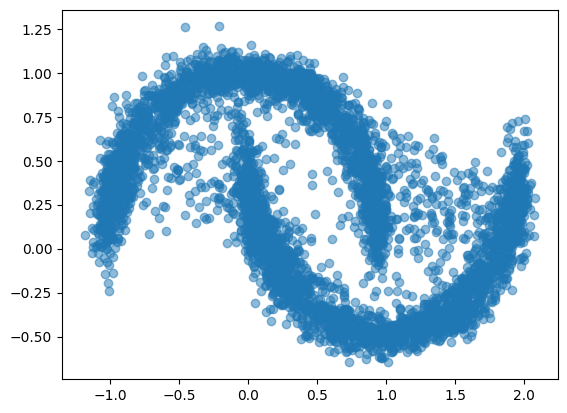

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions
import torch
import torch.optim
from functorch import vmap
from itertools import cycle
from tqdm import tqdm
from typing import Tuple, Dict


class MCEM(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, latent_dim: int) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.prior = torch.distributions.MultivariateNormal(
            loc=torch.zeros((latent_dim,)),
            covariance_matrix=torch.diag_embed(torch.ones((latent_dim,))),
        )
        self.generative_model = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=hidden_dim),
            nn.LeakyReLU(inplace=True),
            nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
            nn.LeakyReLU(inplace=True),
            nn.Linear(in_features=hidden_dim, out_features=input_dim * 2),
        )

    def sample(self, num_samples: int) -> torch.Tensor:
        torch.Size((num_samples,))
        z = self.prior.sample(torch.Size((num_samples,)))
        x_mean, x_logvar = torch.split(self.generative_model(z), split_size_or_sections=2, dim=-1)
        observational_posterior = torch.distributions.MultivariateNormal(
            loc=x_mean, covariance_matrix=torch.diag_embed(torch.exp(.5 * x_logvar))
        )
        return observational_posterior.sample()

    def loss(
        self, x: torch.Tensor, num_mc_samples: int = 100
    ) -> Tuple[torch.Tensor, Dict[str, torch.Tensor]]:
        z = self.prior.rsample(torch.Size((num_mc_samples, x.shape[0])))
        x_mean, x_logvar = torch.split(vmap(self.generative_model)(z), split_size_or_sections=2, dim=-1)
        # Observational likelihood
        observational_posterior = torch.distributions.MultivariateNormal(
            loc=x_mean, covariance_matrix=torch.diag_embed(torch.exp(.5 * x_logvar))
        ).expand(batch_shape=(num_mc_samples, x.shape[0]))

        observational_likelihood = observational_posterior.log_prob(x)
        # Latent likelihood
        prior = self.prior.expand(batch_shape=(num_mc_samples, x.shape[0]))
        latent_likelihood = prior.log_prob(
            torch.reshape(z, shape=(num_mc_samples, x.shape[0], -1))
        )

        # Joint likelihood
        joint_likelihood = torch.log(
            torch.mean(
                torch.exp(observational_likelihood) + torch.exp(latent_likelihood),
                dim=0,
            )
        )

        loss = -torch.mean(joint_likelihood)
        return loss, {}

    def forward(self, num_samples: int) -> torch.Tensor:
        return self.sample(num_samples)


model = MCEM(input_dim=2, hidden_dim=32, latent_dim=8)
num_steps = 5000
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

pbar = tqdm(zip(range(num_steps), cycle(train_loader)))

for step, (x, y) in pbar:
    optimizer.zero_grad()
    loss, _ = model.loss(x, num_mc_samples=100)
    loss.backward()
    optimizer.step()
    pbar.set_description(f"{step:03d}/{num_steps:03d}: Loss {loss:.3f}")


samples = model(5000).detach().numpy()
plt.scatter(samples[:, 0], samples[:, 1], cmap="rainbow", alpha=0.5)

## Variational Auto-Encoder

4999/5000: Loss 1.419: : 5000it [00:46, 107.80it/s]
/tmp/ipykernel_12375/2702808200.py:78: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(samples[:, 0], samples[:, 1], cmap="rainbow", alpha=0.5)


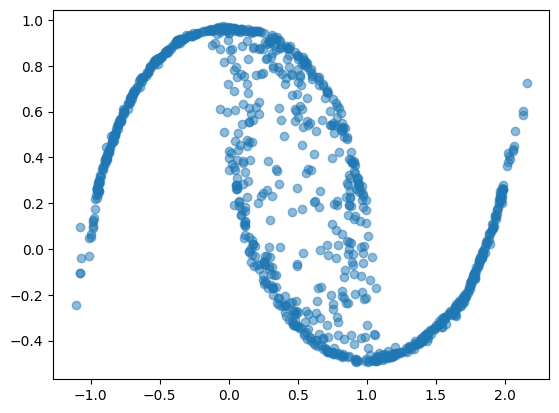

In [26]:
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions
import torch
import torch.optim
from functorch import vmap
from itertools import cycle
from tqdm import tqdm
from typing import Tuple, Dict


class VAE(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, latent_dim: int) -> None:
        super().__init__()
        self.latent_dim = latent_dim
        self.prior = torch.distributions.MultivariateNormal(
            loc=torch.zeros((latent_dim,)),
            covariance_matrix=torch.diag_embed(torch.ones((latent_dim,))),
        )

        self.inference_model = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=hidden_dim),
            nn.LeakyReLU(inplace=True),
            nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
            nn.LeakyReLU(inplace=True),
            nn.Linear(in_features=hidden_dim, out_features=latent_dim * 2),
        )
        self.generative_model = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=hidden_dim),
            nn.LeakyReLU(inplace=True),
            nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
            nn.LeakyReLU(inplace=True),
            nn.Linear(in_features=hidden_dim, out_features=input_dim),
        )

    def sample(self, num_samples: int) -> torch.Tensor:
        torch.Size((num_samples,))
        z = self.prior.sample(torch.Size((num_samples,)))
        return self.generative_model(z)

    def loss(self, x: torch.Tensor, num_mc_samples: int = 100) -> Tuple[torch.Tensor, Dict[str, torch.Tensor]]:
        out = self.inference_model(x)
        mu, log_var = out[:, : self.latent_dim], out[:, self.latent_dim :]
        posterior = torch.distributions.MultivariateNormal(
            loc=mu, covariance_matrix=torch.diag_embed(torch.exp(0.5 * log_var))
        )
        z = posterior.rsample(torch.Size((num_mc_samples,)))
        x_hat = vmap(self.generative_model)(z)
        # compute loss
        kl = torch.distributions.kl_divergence(posterior, self.prior)
        observational_posterior = torch.distributions.MultivariateNormal(
            loc=x, covariance_matrix=torch.diag_embed(0.05 * torch.ones_like(x))
        ).expand(batch_shape=(num_mc_samples, x.shape[0]))
        likelihood = torch.mean(observational_posterior.log_prob(x_hat), dim=0)
        elbo = likelihood - kl
        loss = -torch.mean(elbo)
        return loss, {"elbo": -loss, "likelihood": torch.mean(likelihood), "kl": torch.mean(kl)}

    def forward(self, num_samples: int) -> torch.Tensor:
        return self.sample(num_samples)


model = VAE(input_dim=2, hidden_dim=32, latent_dim=8)
num_steps = 5000
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

pbar = tqdm(zip(range(num_steps), cycle(train_loader)))

for step, (x, y) in pbar:
    optimizer.zero_grad()
    loss, output = model.loss(x, num_mc_samples=100)
    loss.backward()
    optimizer.step()
    pbar.set_description(f"{step:03d}/{num_steps:03d}: Loss {loss:.3f}")


samples = model(1000).detach().numpy()
plt.scatter(samples[:, 0], samples[:, 1], cmap="rainbow", alpha=0.5)